In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_random_seed(RANDOM_SEED)

/Users/ozge.bursa/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
column_names = ['user_id', 'activity', 'timestamp', 'x_axis', 'y_axis', 'z_axis']

df = pd.read_csv('../data/WISDM_ar_v1.1_raw.txt', header=None, names=column_names)
df.z_axis.replace(regex=True, inplace=True, to_replace=r';', value=r'')
df['z_axis'] = df.z_axis.astype(np.float64)
df.dropna(axis=0, how='any', inplace=True)

In [3]:
df.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [4]:
df.user_id.unique()

array([33, 17, 20, 29, 13, 15,  6, 27, 36, 18, 32, 35, 11, 16,  5, 10, 28,
       26, 14, 24, 12, 23,  4, 30, 34,  8, 31, 21,  3, 22,  1,  9, 25,  2,
        7, 19])

In [5]:
df_train = df[df['user_id'] <= 30]
df_test = df[df['user_id'] > 30]

In [6]:
from sklearn.preprocessing import RobustScaler

scale_columns = ['x_axis', 'y_axis', 'z_axis']

scaler = RobustScaler()

scaler = scaler.fit(df_train[scale_columns])

df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())

/Users/ozge.bursa/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/ozge.bursa/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [7]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_train, y_train = create_dataset(
    df_train[['x_axis', 'y_axis', 'z_axis']], 
    df_train.activity, 
    TIME_STEPS, 
    STEP
)

X_test, y_test = create_dataset(
    df_test[['x_axis', 'y_axis', 'z_axis']], 
    df_test.activity, 
    TIME_STEPS, 
    STEP
)

In [8]:
print(X_train.shape, y_train.shape)

(22454, 200, 3) (22454, 1)


In [9]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

In [10]:
print(X_train.shape, y_train.shape)

(22454, 200, 3) (22454, 6)


In [12]:
momentum = [0, 0.2, 0.4, 0.6, 0.8, 0.9]
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]   
batch_size = [64, 128]
epochs = [20, 50]

In [13]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.1, shuffle=True)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 20208 samples, validate on 2246 samples
Epoch 1/20
20208/20208 [==============================] - 104s 5ms/sample - loss: 1.0425 - acc: 0.6443 - val_loss: 0.8944 - val_acc: 0.6451
Epoch 2/20
20208/20208 [==============================] - 97s 5ms/sample - loss: 0.7197 - acc: 0.7393 - val_loss: 0.5229 - val_acc: 0.8526
Epoch 3/20
20208/20208 [==============================] - 98s 5ms/sample - loss: 0.6112 - acc: 0.7767 - val_loss: 0.5340 - val_acc: 0.8117
Epoc

In [16]:
model.evaluate(X_test, y_test)

4992/4992 [==============================] - 8s 2ms/sample - loss: 0.3712 - acc: 0.8838


[0.37121383447573375, 0.8838141]

In [17]:
y_pred = model.predict(X_test)

In [18]:
input_shape = [X_train.shape[1], X_train.shape[2]]

# GridSearch

In [84]:
momentum = [0, 0.2, 0.6, 0.9]
learn_rate = [0.001, 0.01, 0.1]   

In [85]:
def create_model(learn_rate=0.01, momentum=0):
    model = keras.Sequential()
    model.add(
        keras.layers.Bidirectional(
          keras.layers.LSTM(
              units=128, 
              input_shape=input_shape
          )
        )
    )
    model.add(keras.layers.Dropout(rate=0.5))
    model.add(keras.layers.Dense(units=128, activation='relu'))
    model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [86]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [87]:
param_grid = dict(learn_rate=learn_rate, momentum=momentum)

In [88]:
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=64)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=5)

In [89]:
grid_result = grid.fit(X_train, y_train)

Train on 17963 samples
Epoch 1/10
17963/17963 [==============================] - 89s 5ms/sample - loss: 1.0760 - acc: 0.6323
Epoch 2/10
17963/17963 [==============================] - 93s 5ms/sample - loss: 0.7476 - acc: 0.7380
Epoch 3/10
17963/17963 [==============================] - 90s 5ms/sample - loss: 0.5911 - acc: 0.7888
Epoch 4/10
17963/17963 [==============================] - 91s 5ms/sample - loss: 0.5725 - acc: 0.7961
Epoch 5/10
17963/17963 [==============================] - 91s 5ms/sample - loss: 0.5417 - acc: 0.8016
Epoch 6/10
17963/17963 [==============================] - 91s 5ms/sample - loss: 0.4241 - acc: 0.8378
Epoch 7/10
17963/17963 [==============================] - 93s 5ms/sample - loss: 0.4223 - acc: 0.8424
Epoch 8/10
17963/17963 [==============================] - 93s 5ms/sample - loss: 0.3290 - acc: 0.8764
Epoch 9/10
17963/17963 [==============================] - 92s 5ms/sample - loss: 0.2963 - acc: 0.8892
Epoch 10/10
17963/17963 [==============================] - 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

In [ ]:
from tensorflow.keras.models import model_from_json

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

In [22]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(18, 16)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.color_palette("muted"),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  #plt.show() # ta-da!
  plt.savefig("confusion_matrix.png")

In [23]:
enc.categories_[0]

array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype='<U10')

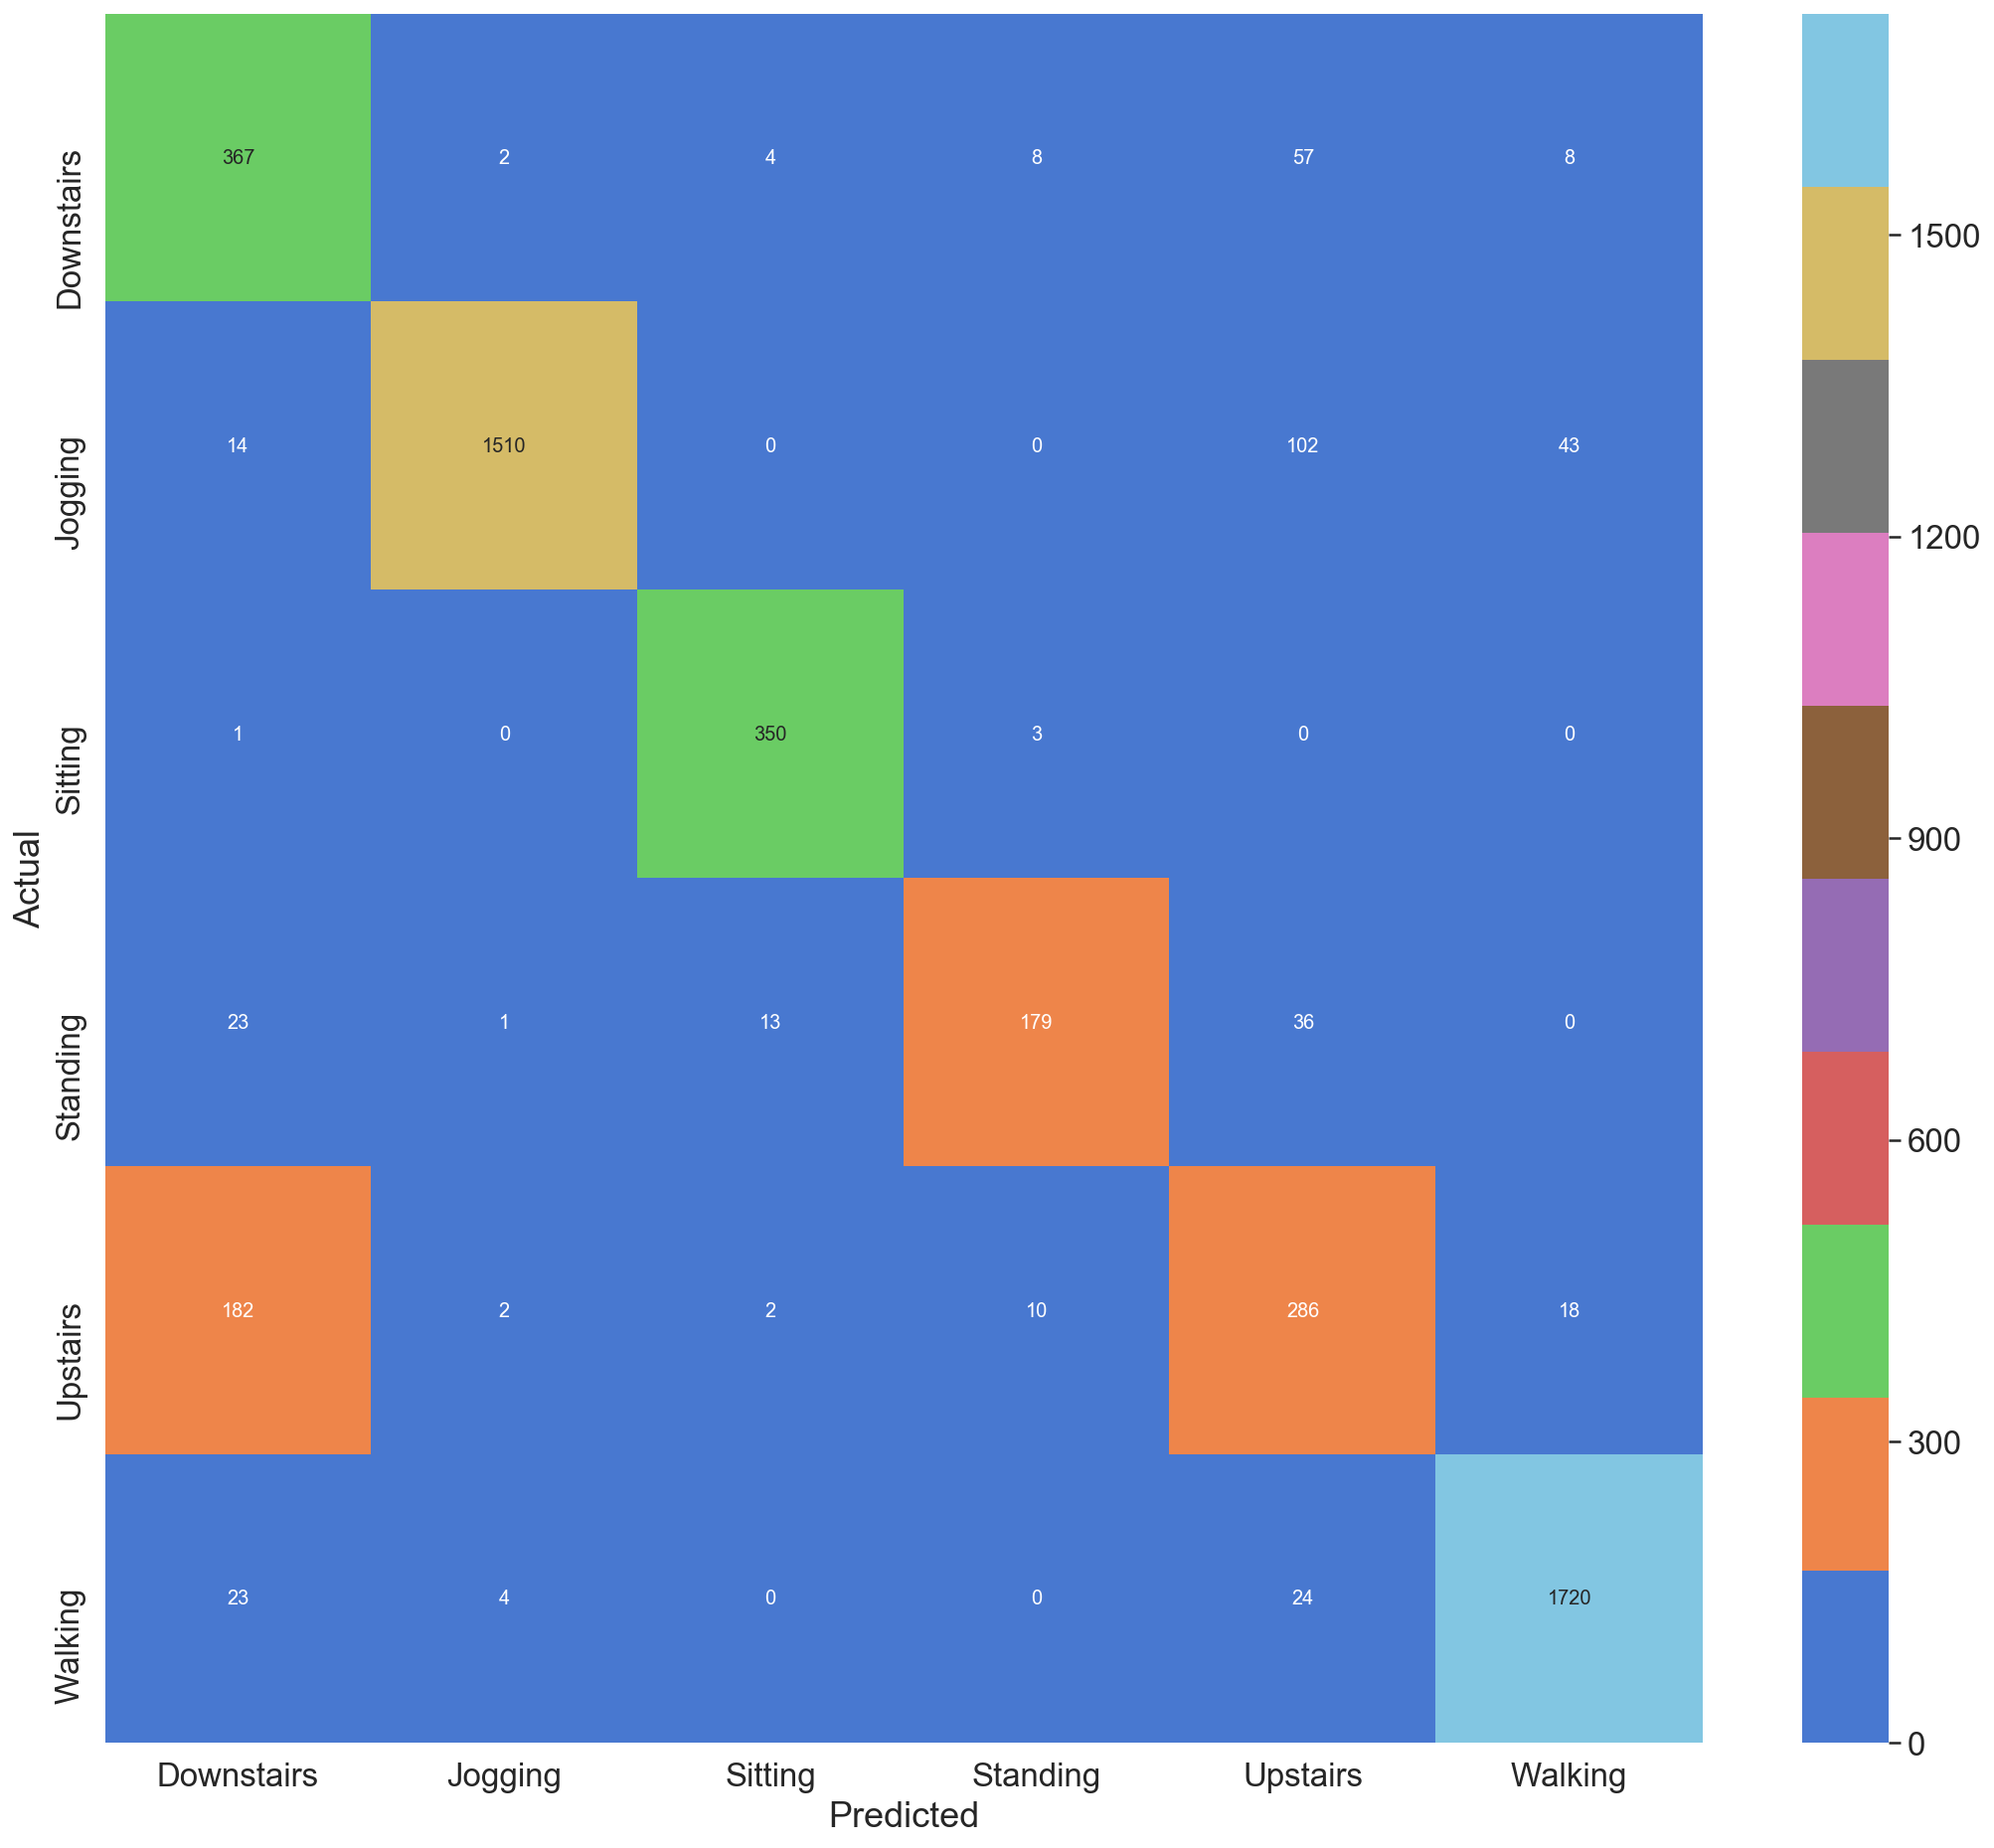

In [24]:
plot_cm(
  enc.inverse_transform(y_test),
  enc.inverse_transform(y_pred),
  enc.categories_[0]
)

In [25]:
from pickle import dump

dump(X_test, open('x_test.pkl', 'wb'))

In [26]:
dump(y_test, open('y_test.pkl', 'wb'))

In [27]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(enc.inverse_transform(y_test), enc.inverse_transform(y_pred)))
# Accuracy
from sklearn.metrics import accuracy_score
print(accuracy_score(enc.inverse_transform(y_test), enc.inverse_transform(y_pred)))
# Recall
from sklearn.metrics import recall_score
print(recall_score(enc.inverse_transform(y_test), enc.inverse_transform(y_pred), average=None))
# Precision
from sklearn.metrics import precision_score
print(precision_score(enc.inverse_transform(y_test), enc.inverse_transform(y_pred), average=None))
# F1 score
from sklearn.metrics import f1_score
f1_score(enc.inverse_transform(y_test), enc.inverse_transform(y_pred), average=None)

[[ 367    2    4    8   57    8]
 [  14 1510    0    0  102   43]
 [   1    0  350    3    0    0]
 [  23    1   13  179   36    0]
 [ 182    2    2   10  286   18]
 [  23    4    0    0   24 1720]]
0.8838141025641025
[0.82286996 0.90473337 0.98870056 0.71031746 0.572      0.97120271]
[0.60163934 0.99407505 0.94850949 0.895      0.56633663 0.96143097]


array([0.69507576, 0.94730238, 0.96818811, 0.7920354 , 0.56915423,
       0.96629213])

In [28]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score

binarizer = MultiLabelBinarizer()

# This should be your original approach
#binarizer.fit(your actual true output consisting of all labels)

# In this case, I am considering only the given labels.
binarizer.fit(enc.inverse_transform(y_test))

f1_score(binarizer.transform(enc.inverse_transform(y_test)), 
         binarizer.transform(enc.inverse_transform(y_pred)), 
         average='weighted')

0.887272328015675

In [29]:
enc.inverse_transform(y_pred)

array([['Jogging'],
       ['Jogging'],
       ['Jogging'],
       ...,
       ['Upstairs'],
       ['Upstairs'],
       ['Upstairs']], dtype='<U10')

In [30]:
f1_score(binarizer.transform(enc.inverse_transform(y_test)), 
         binarizer.transform(enc.inverse_transform(y_pred)), 
         average=None)

array([0.69507576, 0.94730238, 0.96818811, 0.7920354 , 0.56915423,
       0.96629213])